In [69]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# chrome://bookmarks/?q=xgboost

In [83]:
dateTimeCols=['open_datetime','response_datetime','resolved_datetime','close_datetime']
cateFeatures=['product_type','brand','incident_type','service_type','is_failure_type']
numericFeatures=['count_detail','open_to_close_hour','response_to_resolved_hour','open_to_response_hour','resolved_to_close_hour']
colLabel='severity_label'


colFeatures=cateFeatures+numericFeatures
cols=[colLabel]+colFeatures
print(cols)

to_date='2023-12-31'

['severity_label', 'product_type', 'brand', 'incident_type', 'service_type', 'is_failure_type', 'count_detail', 'open_to_close_hour', 'response_to_resolved_hour', 'open_to_response_hour', 'resolved_to_close_hour']


# Load and Prepare Data

In [84]:
df_incident = pd.read_csv('incident_data.csv',parse_dates=dateTimeCols)
print(f"Incident From {df_incident['open_datetime'].min()} To {df_incident['open_datetime'].max()}")
print(df_incident.info())

Incident From 2020-03-15 13:36:00 To 2023-02-01 06:40:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   severity_label             2096 non-null   object        
 1   id                         2096 non-null   int64         
 2   incident_no                2096 non-null   object        
 3   product_type               2096 non-null   object        
 4   brand                      2096 non-null   object        
 5   mode                       2096 non-null   object        
 6   incident_type              2096 non-null   object        
 7   status                     2096 non-null   object        
 8   service_type               2096 non-null   object        
 9   is_failure_type            2096 non-null   bool          
 10  count_detail               2096 non-null   int64         
 11  open_datetim

In [85]:
df_incident=df_incident.query("open_datetime<=@to_date")
df_incident=df_incident[cols]
print(df_incident.info())
df_incident.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_label             2096 non-null   object 
 1   product_type               2096 non-null   object 
 2   brand                      2096 non-null   object 
 3   incident_type              2096 non-null   object 
 4   service_type               2096 non-null   object 
 5   is_failure_type            2096 non-null   bool   
 6   count_detail               2096 non-null   int64  
 7   open_to_close_hour         2095 non-null   float64
 8   response_to_resolved_hour  2095 non-null   float64
 9   open_to_response_hour      2096 non-null   float64
 10  resolved_to_close_hour     2094 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(5)
memory usage: 182.2+ KB
None


,severity_label,product_type,brand,incident_type,service_type,is_failure_type,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
2091,Minor,Storage,YIP,General Incident,Request,False,1,67.250000,0.000000,67.250000,0.000000
2092,Major,Storage,NetApp,General Incident,Incident,False,3,365.316667,169.016667,2.633333,193.666667
2093,Major,Storage,NetApp,General Incident,Incident,False,2,20.166667,4.533333,0.550000,15.083333
2094,Major,Storage,NetApp,General Incident,Incident,False,1,23.783333,0.000000,23.783333,0.000000
2095,Major,Storage,NetApp,General Incident,Incident,False,2,31.150000,28.466667,1.450000,1.233333


# Split features and class

In [86]:
features=[ col for col in list(df_incident.columns) if  col!=colLabel ]
X = df_incident.loc[:,features]
Y = df_incident.loc[:,target_class]

cate_features=[ col for col in features if  col not in ['warranty_months','incident_response_minutes'] ]
for cate_col in cate_features:
  X[cate_col]=X[cate_col].astype("category")


In [87]:
X.tail()

,product_type,brand,incident_type,service_type,is_failure_type,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
2091,Storage,YIP,General Incident,Request,False,1,67.250000,0.000000,67.250000,0.000000
2092,Storage,NetApp,General Incident,Incident,False,3,365.316667,169.016667,2.633333,193.666667
2093,Storage,NetApp,General Incident,Incident,False,2,20.166667,4.533333,0.550000,15.083333
2094,Storage,NetApp,General Incident,Incident,False,1,23.783333,0.000000,23.783333,0.000000
2095,Storage,NetApp,General Incident,Incident,False,2,31.150000,28.466667,1.450000,1.233333


In [88]:
Y.tail()

2091    Minor
2092    Major
2093    Major
2094    Major
2095    Major
Name: severity_label, dtype: object

# Encode string class values as integers

In [89]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)
print(label_encoded_y[-5:])

[3 2 2 2 2]


# Split Train and Test Data

In [90]:
seed = 7
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=test_size, random_state=seed)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(1781, 10) (315, 10)
(1781,) (315,)


# XGBoost Fit model no training data and Predict

In [91]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
model_xg = XGBClassifier(enable_categorical=True,tree_method="hist")

model_xg.fit(X_train, y_train)
print(model_xg)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


In [92]:
y_pred_xg = model_xg.predict(X_test)
predictions_xg = [round(value) for value in y_pred_xg]

accuracy_xg = accuracy_score(y_test, predictions_xg)
print("XGBoost Accuracy: %.2f%%" % (accuracy_xg * 100.0))

XGBoost Accuracy: 77.14%


# Feature Important

In [93]:
import matplotlib.pyplot  as plt
feature_series=pd.Series(model_xg.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_series

service_type                 0.540046
brand                        0.069454
open_to_close_hour           0.068434
response_to_resolved_hour    0.067791
incident_type                0.047208
open_to_response_hour        0.046506
resolved_to_close_hour       0.044928
product_type                 0.042879
count_detail                 0.042493
is_failure_type              0.030262
dtype: float32

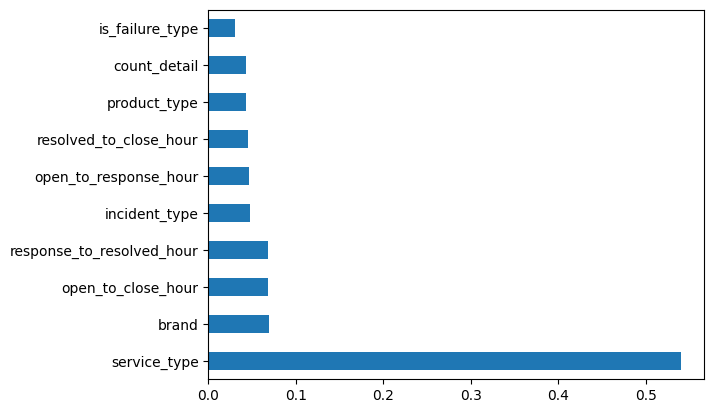

In [94]:
feature_series.plot(kind='barh')
plt.show()